In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from ecephys_analyses import load as ld
import ecephys.plot as eplt
from ecephys import xrsig

In [4]:
def load_alias_data(subject, experiment, alias, probe, power_as_percentage_of=None):
    hypnogram = ld.load_and_concatenate_hypnograms(subject, experiment, alias, probe)    
    spws = ld.load_and_concatenate_spws(subject, experiment, alias, probe)
    bp = ld.load_and_concatenate_bandpowers(subject, experiment, alias, probe)
    if power_as_percentage_of:
        bp = bp / power_as_percentage_of * 100
    
    bp = bp.rolling(time=10, center=True).mean()
    
    return hypnogram, spws, bp.swap_dims({'time': 'datetime'})

In [5]:
def plot_condition(hypnogram, spws, power):

    fig, (mpta_swa_ax, sr_swa_ax, density_ax, duration_ax, amplitude_ax, integral_ax) = plt.subplots(6, 1, figsize=(22,12))
    xmargin=0
    
    mpta_swa_ylabel = 'CTX delta, WM ref'
    sr_swa_ylabel = 'SR delta, WM ref'
    mpta_swa_ylabel = mpta_swa_ylabel + ', \n % BSL NREM median'
    sr_swa_ylabel = sr_swa_ylabel + ', \n % BSL NREM median'

    # units = (uV^2/Hz)
    sns.lineplot(x=power.datetime.values, y=power.mpta_delta_wm_ref.values, color='black', ax=mpta_swa_ax)
    mpta_swa_ax.set(xlabel=None, ylabel=mpta_swa_ylabel, ylim=MPTA_SWA_LIM, xmargin=xmargin, xticks=[])

    sns.lineplot(x=power.datetime.values, y=power.sr_delta_wm_ref.values, color='black', ax=sr_swa_ax)
    sr_swa_ax.set(xlabel=None, ylabel=sr_swa_ylabel, ylim=SR_SWA_LIM, xmargin=xmargin, xticks=[])
    
    mpta_swa_ax.axhline(100, color='r', linestyle=':')
    sr_swa_ax.axhline(100, color='r', linestyle=':')

    binwidth = 10
    nbins = int((spws.start_time.max() - spws.start_time.min()).total_seconds() / binwidth)
    sns.histplot(data=spws, x='start_time', bins=nbins, color='black', ax=density_ax)
    density_ax.set(xlabel=None, ylabel='Frequency (Hz)', ylim=DENSITY_LIM, xmargin=xmargin, xticks=[])

    sns.scatterplot(data=spws, x="start_time", y="duration", s=2, ax=duration_ax)
    duration_ax.set(xlabel=None, ylabel="Duration (s)", ylim=DURATION_LIM, xmargin=xmargin, xticks=[])

    sns.scatterplot(data=spws, x='start_time', y='sink_amplitude', s=2, ax=amplitude_ax)
    amplitude_ax.set(xlabel=None, ylabel="Sink amplitude (mA/mm)", ylim=AMPLITUDE_LIM, xmargin=xmargin, xticks=[])

    sns.scatterplot(data=spws, x='start_time', y='sink_integral', s=2, ax=integral_ax)
    integral_ax.set(xlabel="Event time (month-date hour)", ylabel="Sink integral (mA * ms)", ylim=INTEGRAL_LIM, xmargin=xmargin)

    for ax in (mpta_swa_ax, sr_swa_ax, density_ax, duration_ax, amplitude_ax, integral_ax):
        eplt.plot_hypnogram_overlay(hypnogram, ax=ax)

    plt.tight_layout()

In [6]:
def plot_both_conditions(bsl_hypnogram, bsl_spws, bsl_power, exp_hypnogram, exp_spws, exp_power):

    fig, (bsl_swa_ax, bsl_density_ax, bsl_amplitude_ax, exp_swa_ax, exp_density_ax, exp_amplitude_ax) = plt.subplots(6, 1, figsize=(22,12))

    xmargin=0
    
    bsl_swa_ylabel = 'BSL CTX delta, WM ref'
    exp_swa_ylabel = 'EXP CTX delta, WM ref'
    bsl_swa_ylabel = bsl_swa_ylabel + ', \n % BSL NREM median'
    exp_swa_ylabel = exp_swa_ylabel + ', \n % BSL NREM median'
    
    # Baseline
    sns.lineplot(x=bsl_power.datetime.values, y=bsl_power.mpta_delta_wm_ref.values, color='black', ax=bsl_swa_ax)
    bsl_swa_ax.set(xlabel=None, ylabel=bsl_swa_ylabel, ylim=MPTA_SWA_LIM, xmargin=xmargin, xticks=[])
         
    bsl_swa_ax.axhline(100, color='r', linestyle=':')

    binwidth = 10
    nbins = int((bsl_spws.start_time.max() - bsl_spws.start_time.min()).total_seconds() / binwidth)
    sns.histplot(data=bsl_spws, x='start_time', bins=nbins, color='black', ax=bsl_density_ax)
    bsl_density_ax.set(xlabel=None, ylabel='BSL Frequency (Hz)', ylim=DENSITY_LIM, xmargin=xmargin, xticks=[])
    
    sns.scatterplot(data=bsl_spws, x='start_time', y='sink_amplitude', s=2, ax=bsl_amplitude_ax)
    bsl_amplitude_ax.set(xlabel=None, ylabel="BSL Sink amp. (mA/mm)", ylim=AMPLITUDE_LIM, xmargin=xmargin, xticks=[])
    
    for ax in (bsl_swa_ax, bsl_density_ax, bsl_amplitude_ax):
        eplt.plot_hypnogram_overlay(bsl_hypnogram, ax=ax)

    # Experiment
    sns.lineplot(x=exp_power.datetime.values, y=exp_power.mpta_delta_wm_ref.values, color='black', ax=exp_swa_ax)
    exp_swa_ax.set(xlabel=None, ylabel=exp_swa_ylabel, ylim=MPTA_SWA_LIM, xmargin=xmargin, xticks=[])
        
    exp_swa_ax.axhline(100, color='r', linestyle=':')

    binwidth = 10
    nbins = int((exp_spws.start_time.max() - exp_spws.start_time.min()).total_seconds() / binwidth)
    sns.histplot(data=exp_spws, x='start_time', bins=nbins, color='black', ax=exp_density_ax)
    exp_density_ax.set(xlabel=None, ylabel='EXP Frequency (Hz)', ylim=DENSITY_LIM, xmargin=xmargin, xticks=[])
    
    sns.scatterplot(data=exp_spws, x='start_time', y='sink_amplitude', s=2, ax=exp_amplitude_ax)
    exp_amplitude_ax.set(xlabel=None, ylabel="EXP Sink amp. (mA/mm)", ylim=AMPLITUDE_LIM, xmargin=xmargin, xticks=[])
        
    for ax in (exp_swa_ax, exp_density_ax, exp_amplitude_ax):
        eplt.plot_hypnogram_overlay(exp_hypnogram, ax=ax)

    plt.tight_layout()

In [7]:
subject = "Segundo"
experiment = "novel_objects_deprivation"
bsl_condition = "light-period-circadian-match"
exp_condition = "light-period"

# When plotting raw power
MPTA_SWA_LIM = (0, 350000)
SR_SWA_LIM = (0, 225000)

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.18, -0.04)
INTEGRAL_LIM = (-15, 0)

In [8]:
subject = "Valentino"
experiment = "novel_objects_deprivation"
bsl_condition = "light-period-circadian-match"
exp_condition = "light-period"

# When plotting raw power
MPTA_SWA_LIM = (0, 100000)
SR_SWA_LIM = (0, 225000)

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.098, -0.022)
INTEGRAL_LIM = (-11, 0)

In [9]:
subject = "Doppio"
experiment = "novel_objects_deprivation"
bsl_condition = "light-period-circadian-match"
exp_condition = "light-period"

# When plotting raw power
MPTA_SWA_LIM = (0, 250000)
SR_SWA_LIM = (0, 150000)

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.13, -0.0275)
INTEGRAL_LIM = (-13, 0)

In [10]:
subject = "Alessandro"
experiment = "novel_objects_deprivation"
bsl_condition = "light-period-circadian-match"
exp_condition = "light-period"

# When plotting raw power
MPTA_SWA_LIM = (0, 175000)
SR_SWA_LIM = (0, 200000)

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.25)
AMPLITUDE_LIM = (-0.22, -0.06)
INTEGRAL_LIM = (-20, 0)

In [11]:
subject = "Eugene"
experiment = "novel_objects_deprivation"
bsl_condition = "light-period-circadian-match"
exp_condition = "light-period"

# When plotting raw power
MPTA_SWA_LIM = (0, 225000)
SR_SWA_LIM = (0, 125000)

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.08, -0.015)
INTEGRAL_LIM = (-7, 0)

In [12]:
subject = "Allan"
experiment = "novel_objects_deprivation"
bsl_condition = "light-period-circadian-match"
exp_condition = "light-period"

# When plotting raw power
MPTA_SWA_LIM = (0, 350000)
SR_SWA_LIM = (0, 150000)

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.25)
AMPLITUDE_LIM = (-0.085, -0.022)
INTEGRAL_LIM = (-8, 0)

In [19]:
subject = "Luigi"
experiment = "novel_objects_deprivation"
bsl_condition = "light-period-circadian-match"
exp_condition = "light-period"

# When plotting percent change
MPTA_SWA_LIM = (0, 600)
SR_SWA_LIM = (0, 300) 

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.08, -0.02)
INTEGRAL_LIM = (-10, 0)

In [22]:
subject = "Charles"
experiment = "novel_objects_deprivation"
bsl_condition = "light-period-circadian-match"
exp_condition = "light-period"

# When plotting percent change
MPTA_SWA_LIM = (0, 500)
SR_SWA_LIM = (0, 300) 

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.045, -0.01)
INTEGRAL_LIM = (-5, 0)

In [25]:
subject = "Adrian"
experiment = "conveyor_over_water"
bsl_alias = "light_period_circadian_match"
exp_alias = "light_period"
probe = "imec1"

# When plotting percent change
MPTA_SWA_LIM = (0, 400)
SR_SWA_LIM = (0, 400) 

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.09, -0.022)
INTEGRAL_LIM = (-8, 0)

In [11]:
subject = "Adrian"
experiment = "novel_objects_deprivation"
bsl_alias = "light_period_circadian_match"
exp_alias = "light_period"
probe = "imec1"

# When plotting percent change
MPTA_SWA_LIM = (0, 400)
SR_SWA_LIM = (0, 400) 

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.09, -0.022)
INTEGRAL_LIM = (-8, 0)

In [29]:
subject = "Santiago"
experiment = "novel_objects_deprivation"
bsl_alias = "light_period_circadian_match"
exp_alias = "light_period"
probe = "imec1"

# When plotting percent change
MPTA_SWA_LIM = (0, 500)
SR_SWA_LIM = (0, 300) 

DENSITY_LIM = (0, 20)
DURATION_LIM = (0, 0.3)
AMPLITUDE_LIM = (-0.20, -0.05)
INTEGRAL_LIM = (-15, -0.5)

In [30]:
reference_bandpower = ld.load_and_concatenate_bandpowers(subject, experiment, bsl_alias, probe).swap_dims({'time': 'datetime'})
reference_hypnogram = ld.load_and_concatenate_hypnograms(subject, experiment, bsl_alias, probe)
reference = xrsig.keep_states(reference_bandpower, reference_hypnogram, ["N1", "N2"]).median()

In [31]:
(bsl_hypnogram, bsl_spws, bsl_power) = load_alias_data(subject, experiment, bsl_alias, probe, power_as_percentage_of=reference)
(exp_hypnogram, exp_spws, exp_power) = load_alias_data(subject, experiment, exp_alias, probe, power_as_percentage_of=reference)

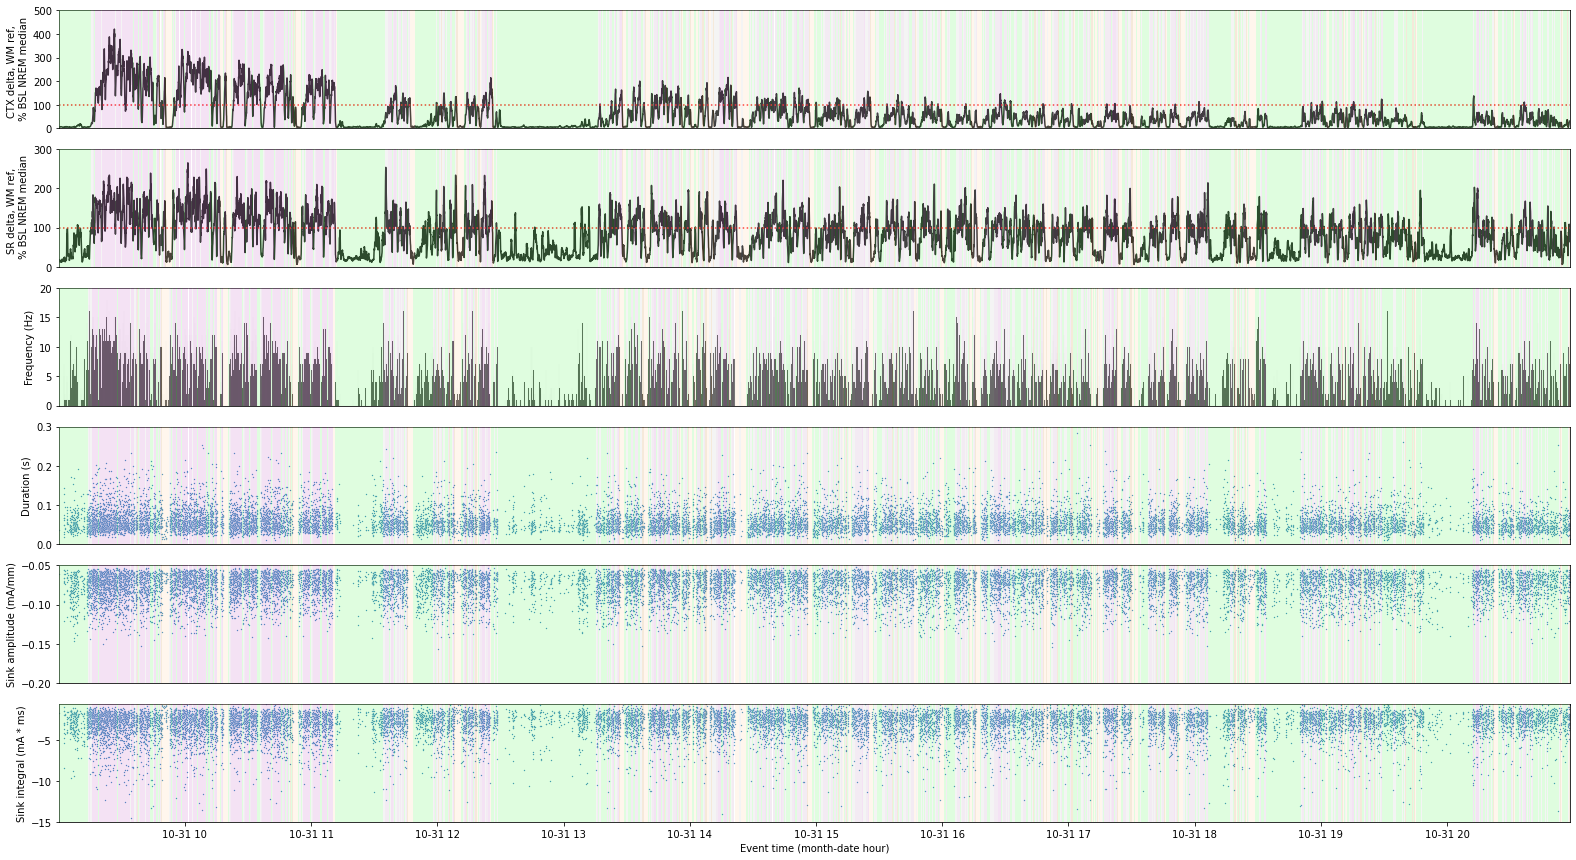

In [32]:
plot_condition(bsl_hypnogram, bsl_spws, bsl_power)

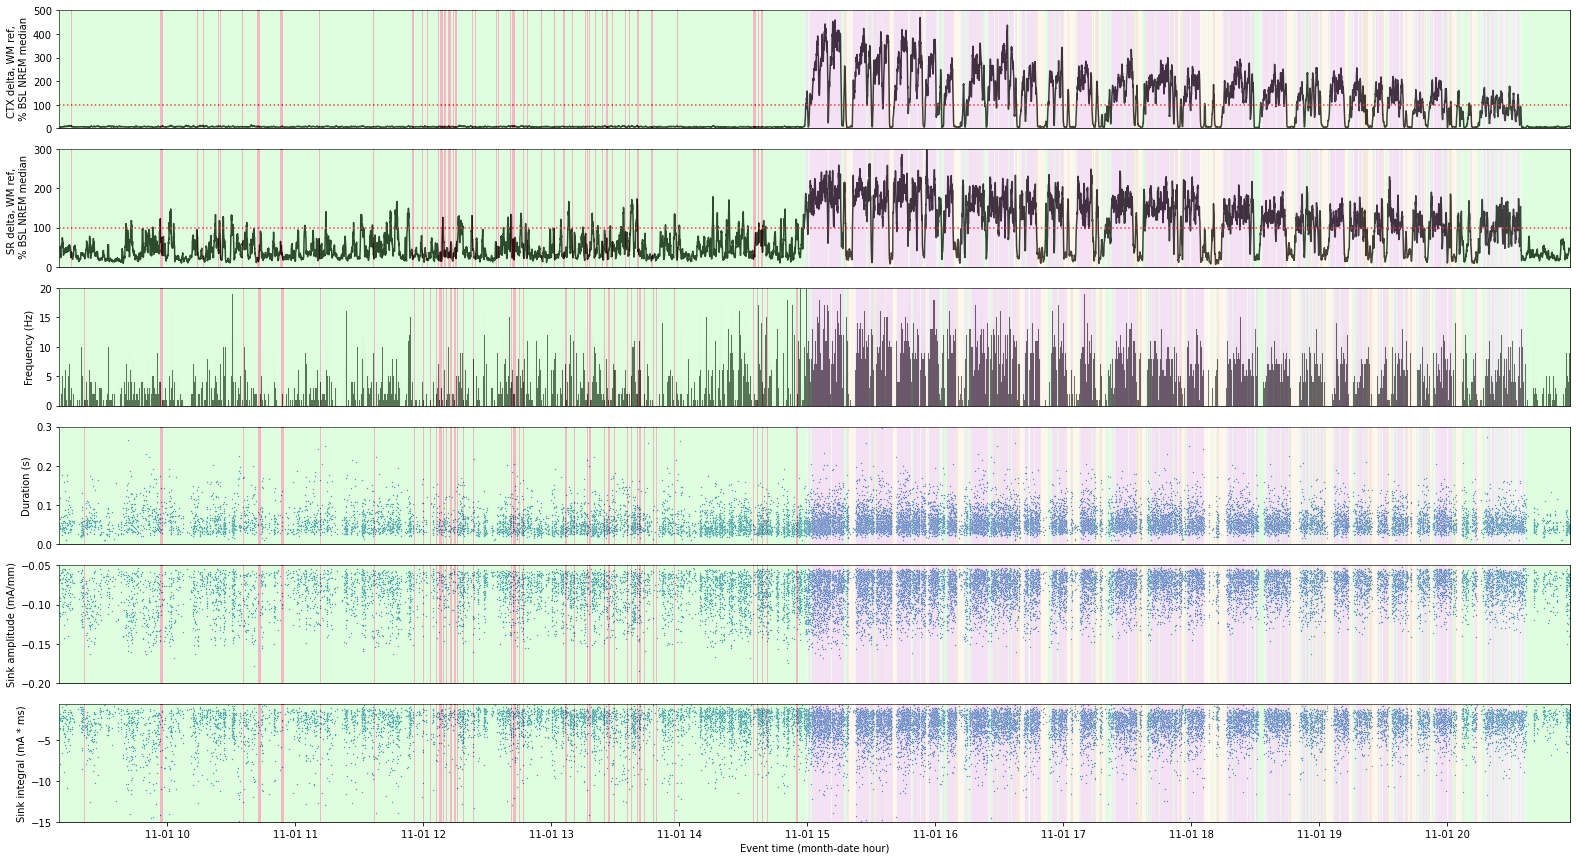

In [33]:
plot_condition(exp_hypnogram, exp_spws, exp_power)

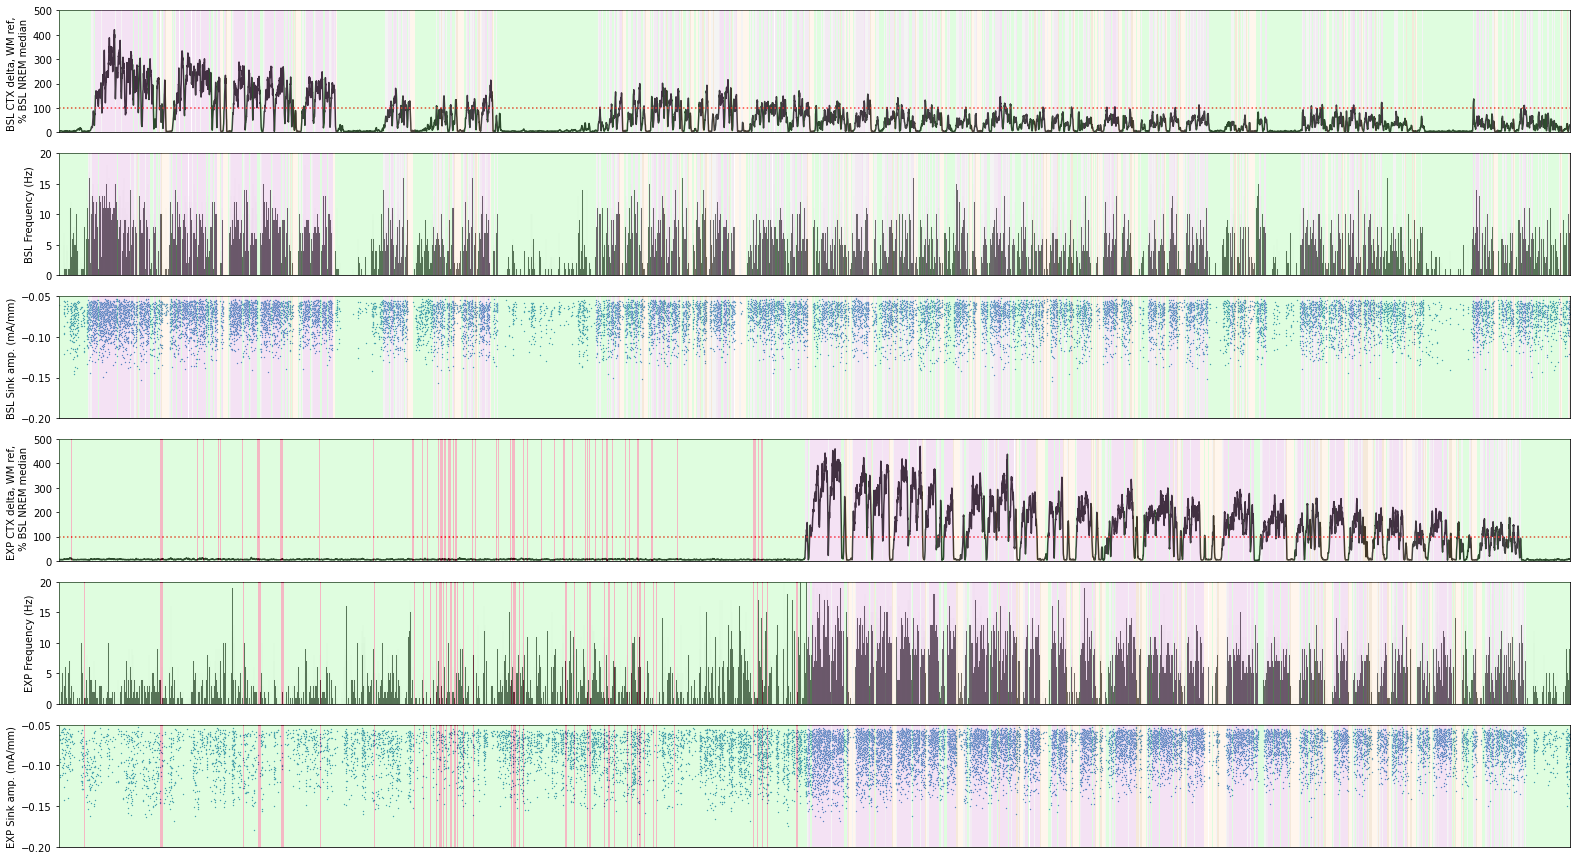

In [34]:
plot_both_conditions(bsl_hypnogram, bsl_spws, bsl_power, exp_hypnogram, exp_spws, exp_power)